
# Projeto — Previsão de Atraso de Entrega (Olist)

**Objetivo**: construir um pipeline **robusto, limpo e sem vazamento** para prever **atraso de entrega** em pedidos da Olist.
## Escopo
1. [*Setup*](#1-setup)
2. [Carregamento de dados](#2-carregamento-de-dados)
3. [*Merges* eficientes e limpeza inicial](#3-merges-eficientes-e-limpeza-inicial)
4. [*Feature engineering*](#4-feature-engineering)
5. [Conjunto de atraso (somente entreges)](#5-conjunto-para-atraso-somente-entregues)
6. [*Split* e *preprocessing*](#6-split-e-preprocessing)
7. [Ultilitários de avaliação (threshold, curvas, métricas)](#7-utilitários-de-avaliação-threshold-curvas-métricas)
8. [Modelo principal - XGBoost - RandomizedSearchCV](#8-modelo-principal--xgboost--randomizedsearchcv)
9. [Importância de *features*](#9-importância-de-features)
10. [Persistência do modelo e helper de inferência](#10-persistência-do-modelo-e-helper-de-inferência)
11. [Refinamento do modelo](#11-refinamento-do-modelo)
12. [Tuning com Optuna - XGBoost - PR-AUC](#12-tuning-com-optuna-xgboost--pr-auc)
13. [Resumo executivo - insights de negócio](#13-resumo-executivo--insights-de-negócio)
14. [Validação temporal (robustez no tempo)](#14-validação-temporal-robustez-no-tempo)
15. [Tabela consolidada de métricas](#15-tabela-consolidada-de-métricas)
16. [Artefatos de produção (joblib + script de inferência)](#16-artefatos-de-produção-joblib--script-de-inferência)

## 1. Setup

In [1]:
import os
import json
import math
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Plotting (somente matplotlib; 1 gráfico por figura; sem estilos de cor customizados)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, average_precision_score, f1_score,
                             precision_score, recall_score, roc_curve)

# Modelos
from lightgbm import LGBMClassifier

# Persistência
import joblib

# Aleatoriedade reprodutível
SEED = 42
np.random.seed(SEED)
os.environ["OLIST_BASE_PATH"] = "data"

## 2. Carregamento de dados

In [2]:

BASE_PATH = os.environ.get("OLIST_BASE_PATH", "")

def load_olist_from_csv(base_path):
    paths = {
        "orders": "olist_orders_dataset.csv",
        "customers": "olist_customers_dataset.csv",
        "items": "olist_order_items_dataset.csv",
        "products": "olist_products_dataset.csv",
        "sellers": "olist_sellers_dataset.csv",
        "geolocation": "olist_geolocation_dataset.csv"
    }
    dfs = {}
    for k, fname in paths.items():
        fpath = os.path.join(base_path, fname)
        if not os.path.exists(fpath):
            raise FileNotFoundError(f"Arquivo não encontrado: {fpath}")
        dfs[k] = pd.read_csv(fpath)
    return dfs


try:
    dfs = load_olist_from_csv(BASE_PATH)
except Exception as e:
    raise RuntimeError(
        "Não foi possível carregar os dados automaticamente. "
        "Defina BASE_PATH com os CSVs da Olist ou garanta que os DataFrames padrão existem no ambiente."
    ) from e

for k, v in dfs.items():
    print(k, v.shape)


orders (99441, 8)
customers (99441, 5)
items (112650, 7)
products (32951, 9)
sellers (3095, 4)
geolocation (1000163, 5)


## 3. *Merges* eficientes e limpeza inicial

In [3]:
# Seleciona apenas colunas necessárias para reduzir uso de memória
orders = dfs["orders"][['order_id','customer_id','order_status',
                        'order_purchase_timestamp','order_approved_at',
                        'order_delivered_customer_date','order_estimated_delivery_date']].copy()

customers = dfs["customers"][['customer_id','customer_zip_code_prefix','customer_city','customer_state']].copy()

items = dfs["items"][['order_id','order_item_id','product_id','seller_id',
                      'shipping_limit_date','price','freight_value']].copy()

products = dfs["products"][['product_id','product_category_name']].copy()

sellers = dfs["sellers"][['seller_id','seller_zip_code_prefix','seller_city','seller_state']].copy()

geo = dfs["geolocation"][['geolocation_zip_code_prefix','geolocation_lat','geolocation_lng']].copy()

# Tipagem econômica
for df_ in [orders, customers, sellers, products]:
    for c in df_.select_dtypes(include='object').columns:
        df_[c] = df_[c].astype('string')

# Datas
for c in ['order_purchase_timestamp','order_approved_at',
          'order_delivered_customer_date','order_estimated_delivery_date']:
    orders[c] = pd.to_datetime(orders[c], errors='coerce')

items['shipping_limit_date'] = pd.to_datetime(items['shipping_limit_date'], errors='coerce')

# Agregados por pedido (itens)
items_agg = (items.groupby('order_id')
             .agg(n_items=('order_item_id','size'),
                  n_sellers=('seller_id','nunique'),
                  price_sum=('price','sum'),
                  freight_sum=('freight_value','sum'),
                  ship_deadline_max=('shipping_limit_date','max'))
             .reset_index())

# Tipo de produto por pedido (modo)
prod_map = (items.merge(products, on='product_id', how='left')
                 .groupby('order_id')['product_category_name']
                 .agg(lambda x: x.mode().iloc[0] if len(x.mode())>0 else pd.NA)
                 .reset_index()
                 .rename(columns={'product_category_name':'order_product_type'}))

# Geo agregado por CEP
geo_cust = (geo.rename(columns={'geolocation_zip_code_prefix':'customer_zip_code_prefix',
                                'geolocation_lat':'cust_lat','geolocation_lng':'cust_lng'})
              .groupby('customer_zip_code_prefix')[['cust_lat','cust_lng']].mean().reset_index())

geo_seller = (geo.rename(columns={'geolocation_zip_code_prefix':'seller_zip_code_prefix',
                                  'geolocation_lat':'sell_lat','geolocation_lng':'sell_lng'})
                .groupby('seller_zip_code_prefix')[['sell_lat','sell_lng']].mean().reset_index())

# Merge principal
df = (orders
      .merge(customers, on='customer_id', how='left')
      .merge(items_agg, on='order_id', how='left')
      .merge(sellers, on='order_id', how='left', how_suffixes=('', '_seller'), validate='m:1') if 'order_id' in sellers.columns else
      orders.merge(customers, on='customer_id', how='left').merge(items_agg, on='order_id', how='left')
     )

# Adiciona tipo de produto
df = df.merge(prod_map, on='order_id', how='left')

# Geo do cliente
df = df.merge(geo_cust, on='customer_zip_code_prefix', how='left')

# Geo dos sellers: precisamos do CEP do seller agregado por order_id (via items)
seller_zip_map = (items.merge(sellers[['seller_id','seller_zip_code_prefix']], on='seller_id', how='left')
                       .groupby('order_id')['seller_zip_code_prefix']
                       .agg(lambda x: x.mode().iloc[0] if len(x.mode())>0 else pd.NA)
                       .reset_index())

df = df.merge(seller_zip_map, on='order_id', how='left').merge(geo_seller, on='seller_zip_code_prefix', how='left')

print("Shape final após merges:", df.shape)
df.head()

Shape final após merges: (99441, 21)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,...,n_sellers,price_sum,freight_sum,ship_deadline_max,order_product_type,cust_lat,cust_lng,seller_zip_code_prefix,sell_lat,sell_lng
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,3149,sao paulo,SP,...,1.0,29.99,8.72,2017-10-06 11:07:15,utilidades_domesticas,-23.576983,-46.587161,9350.0,-23.680729,-46.444238
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13,47813,barreiras,BA,...,1.0,118.70,22.76,2018-07-30 03:24:27,perfumaria,-12.177924,-44.660711,31570.0,-19.807681,-43.980427
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04,75265,vianopolis,GO,...,1.0,159.90,19.22,2018-08-13 08:55:23,automotivo,-16.745150,-48.514783,14840.0,-21.363502,-48.229601
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15,59296,sao goncalo do amarante,RN,...,1.0,45.00,27.20,2017-11-23 19:45:59,pet_shop,-5.774190,-35.271143,31842.0,-19.837682,-43.924053
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26,9195,santo andre,SP,...,1.0,19.90,8.72,2018-02-19 20:31:37,papelaria,-23.676370,-46.514627,8752.0,-23.543395,-46.262086


## 4. *Feature Engineering*

In [4]:
# Flags de entrega e atraso
df['was_delivered'] = df['order_delivered_customer_date'].notna().astype(int)
df['is_late'] = np.where(
    df['was_delivered'].eq(1) & (df['order_delivered_customer_date'] > df['order_estimated_delivery_date']),
    1, 0
)

# Tempo de processamento inicial (aprovado - comprado)
df['processing_time'] = (df['order_approved_at'] - df['order_purchase_timestamp']).dt.total_seconds() / 3600.0

# Razões e interações
df['freight_ratio'] = df['freight_sum'] / df['price_sum']
df['items_per_seller'] = df['n_items'] / df['n_sellers']

# Função haversine (km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

df['distance'] = haversine(df['cust_lat'], df['cust_lng'], df['sell_lat'], df['sell_lng'])
df['has_geo'] = df['distance'].notna().astype(int)

# Região do cliente
state_to_region = {
    'AC':'Norte','AP':'Norte','AM':'Norte','PA':'Norte','RO':'Norte','RR':'Norte','TO':'Norte',
    'AL':'Nordeste','BA':'Nordeste','CE':'Nordeste','MA':'Nordeste','PB':'Nordeste','PE':'Nordeste','PI':'Nordeste','RN':'Nordeste','SE':'Nordeste',
    'DF':'Centro-Oeste','GO':'Centro-Oeste','MT':'Centro-Oeste','MS':'Centro-Oeste',
    'ES':'Sudeste','MG':'Sudeste','RJ':'Sudeste','SP':'Sudeste',
    'PR':'Sul','RS':'Sul','SC':'Sul'
}
df['customer_region'] = df['customer_state'].map(state_to_region).astype('string')

# Sazonalidade/feriados
try:
    import holidays
    years = pd.to_datetime(df['order_purchase_timestamp']).dt.year.dropna().unique().tolist()
    feriados_br = holidays.country_holidays(country='Brazil', years=years) if len(years)>0 else holidays.country_holidays(country='Brazil')
    dte = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce')
    df['is_holiday'] = dte.dt.date.isin(feriados_br)
    df['is_holiday_eve'] = dte.dt.date.isin([d - pd.Timedelta(days=1) for d in feriados_br])
    df['is_holiday_next'] = dte.dt.date.isin([d + pd.Timedelta(days=1) for d in feriados_br])
except Exception as e:
    df['is_holiday'] = False
    df['is_holiday_eve'] = False
    df['is_holiday_next'] = False

# Calendário básico
dte = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce')
df['purchase_month'] = dte.dt.month
df['purchase_weekday'] = dte.dt.weekday
df['is_weekend'] = df['purchase_weekday'].isin([5,6]).astype(int)

# Tratamento do tipo de produto
df['order_product_type'] = df['order_product_type'].astype('string')
df['has_product_type'] = df['order_product_type'].notna().astype(int)
df['order_product_type'] = df['order_product_type'].fillna('__unknown__')

# Sanidade: remover infinitos nas razões
for c in ['freight_ratio','items_per_seller']:
    df[c] = df[c].replace([np.inf,-np.inf], np.nan)

display(df[['was_delivered','is_late','processing_time','distance','customer_region','is_holiday']].head())


,was_delivered,is_late,processing_time,distance,customer_region,is_holiday
0,1,0,0.178333,18.576110,Sudeste,False
1,1,0,30.713889,851.495069,Nordeste,False
2,1,0,0.276111,514.410666,Centro-Oeste,False
3,1,0,0.298056,1822.226336,Nordeste,False
4,1,0,1.030556,29.676625,Sudeste,False


## 5. Conjunto para atraso (somente entregues)

In [5]:

# Mantém apenas pedidos entregues
df_model = df[df['was_delivered'] == 1].copy()

# Colunas que NUNCA entram (vazamento ou IDs)

cols_drop = [
    'is_late','order_id','customer_id',
    'order_purchase_timestamp','order_delivered_customer_date',
    'order_estimated_delivery_date','order_approved_at',
    'ship_deadline_max','shipping_limit_date',  # se existir
    'order_status'
]
cols_drop = [c for c in cols_drop if c in df_model.columns]
feature_cols = [c for c in df_model.columns if c not in cols_drop]

# Separação entre numéricas e categóricas
numeric_candidates = ['n_items','n_sellers','price_sum','freight_sum',
                      'processing_time','distance','purchase_month',
                      'purchase_weekday','is_weekend','freight_ratio','items_per_seller',
                      'has_geo', 'has_product_type', 'cust_lat', 'cust_lng', 
                      'seller_zip_code_prefix', 'sell_lat', 'sell_lng',
                      'was_delivered', 'is_holiday', 'is_holiday_eve',
                      'is_holiday_next', 'customer_zip_code_prefix']

num_cols = [c for c in numeric_candidates if c in feature_cols]
cat_cols = [c for c in feature_cols if c not in num_cols]

# Target
X = df_model.drop(columns=cols_drop).copy()
y = df_model['is_late'].astype(int).copy()

bool_cols = X.select_dtypes(include='boolean').columns
if len(bool_cols) > 0:
    X[bool_cols] = X[bool_cols].astype('int8')

print("Numéricas:", num_cols)
print("Categóricas:", cat_cols)
print("Shape X:", X.shape, "| y:", y.shape, "| Taxa de atraso (classe 1):", y.mean().round(3))


Numéricas: ['n_items', 'n_sellers', 'price_sum', 'freight_sum', 'processing_time', 'distance', 'purchase_month', 'purchase_weekday', 'is_weekend', 'freight_ratio', 'items_per_seller', 'has_geo', 'has_product_type', 'cust_lat', 'cust_lng', 'seller_zip_code_prefix', 'sell_lat', 'sell_lng', 'was_delivered', 'is_holiday', 'is_holiday_eve', 'is_holiday_next', 'customer_zip_code_prefix']
Categóricas: ['customer_city', 'customer_state', 'order_product_type', 'customer_region']
Shape X: (96476, 27) | y: (96476,) | Taxa de atraso (classe 1): 0.081


## 6. Split e *Preprocessing*

In [6]:
from sklearn.compose import ColumnTransformer, make_column_selector as selector

numeric_selector = selector(dtype_include=np.number)
categorical_selector = selector(dtype_exclude=np.number)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

# Pipelines de pré-processamento
num_tf = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='median'))
])


cat_tf = 'passthrough'

pre = ColumnTransformer(
    transformers=[
        ('num', num_tf, num_cols),
        ('cat', cat_tf, cat_cols),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

## 7. Utilitários de avaliação (threshold, curvas, métricas)

In [7]:

def best_threshold_by_f1(y_true, y_prob):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    f1 = 2*(prec*rec)/(prec+rec+1e-9)
    idx = np.argmax(f1)
    return float(thr[idx]), float(prec[idx]), float(rec[idx]), float(f1[idx])

def threshold_by_cost(y_true, y_prob, cost_fp=1.0, cost_fn=5.0, n_steps=101):
    thrs = np.linspace(0.0, 1.0, n_steps)
    costs = []
    from sklearn.metrics import confusion_matrix
    for t in thrs:
        yp = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yp).ravel()
        costs.append(fp*cost_fp + fn*cost_fn)
    i = int(np.argmin(costs))
    return float(thrs[i]), float(costs[i])

def plot_pr_curve(y_true, y_prob, title="Precision-Recall"):
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(title)
    plt.show()

def plot_roc_curve(y_true, y_prob, title="ROC"):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(title)
    plt.show()

def plot_confusion(cm, title="Matriz de Confusão"):
    plt.figure(figsize=(4.5,4))
    # Heatmap manual simples
    plt.imshow(cm, cmap='Blues')
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, f"{val}", ha='center', va='center')
    plt.xticks([0,1], ['Prev 0','Prev 1'])
    plt.yticks([0,1], ['Real 0','Real 1'])
    plt.title(title)
    plt.xlabel('Previsto'); plt.ylabel('Real')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def evaluate_model(y_true, y_prob, thr=None, label="Modelo"):
    if thr is None:
        thr, p, r, f = best_threshold_by_f1(y_true, y_prob)
    yp = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, yp)
    print(f"[{label}] Threshold={thr:.3f} | ROC-AUC={roc_auc_score(y_true, y_prob):.3f} | PR-AUC={average_precision_score(y_true, y_prob):.3f}")
    print(classification_report(y_true, yp, digits=3))
    plot_pr_curve(y_true, y_prob, title=f"Precision-Recall — {label}")
    plot_roc_curve(y_true, y_prob, title=f"ROC — {label}")
    plot_confusion(cm, title=f"Matriz de Confusão — {label}")
    return thr, cm


## 8. Modelo principal — XGBoost + RandomizedSearchCV

In [8]:
import lightgbm as lgb
from scipy import sparse
from scipy.stats import randint, uniform
from sklearn.experimental import enable_halving_search_cv  # noqa

scorer = 'average_precision'  # AP/PR-AUC

X_train_df = X_train.copy()
X_test_df  = X_test.copy()

imp_num = SimpleImputer(strategy='median')
X_train_df[num_cols] = imp_num.fit_transform(X_train_df[num_cols])
X_test_df[num_cols]  = imp_num.transform(X_test_df[num_cols])

# cat_feature_idx = list(range(len(num_cols), len(num_cols)+len(cat_cols)))

for c in cat_cols:
    # 1) virar string e preencher NaN
    X_train_df[c] = X_train_df[c].astype('string').fillna('__missing__')
    X_test_df[c]  = X_test_df[c].astype('string').fillna('__missing__')


def collapse_rare_train_test(sr_train, sr_test, min_count=50):
    """Colapsa categorias raras com base SOMENTE no treino; depois alinha categorias em train/test."""
    # garantir strings (não Categorical ainda!)
    tr = sr_train.astype('string')
    te = sr_test.astype('string')

    vc = tr.value_counts()
    rare = vc[vc < min_count].index

    # 2) colapsar raras em string
    tr = tr.where(~tr.isin(rare), '__rare__')
    te = te.where(~te.isin(rare), '__rare__')

    # 3) agora definir categorias e ALINHAR entre train/test
    cats = sorted(pd.Index(tr.unique()).union(pd.Index(te.unique())))
    tr = tr.astype('category').cat.set_categories(cats)
    te = te.astype('category').cat.set_categories(cats)
    return tr, te



for c in cat_cols:
    X_train_df[c], X_test_df[c] = collapse_rare_train_test(X_train_df[c], X_test_df[c], min_count=50)

# sanity-check: nada de dtype string restante
bad = [c for c in X_train_df.columns if str(X_train_df[c].dtype) == 'string']
assert not bad, f"Colunas com dtype string (não permitido no LGBM): {bad}"

# peso para desbalanceamento
spw = (y_train.value_counts()[0] / y_train.value_counts()[1])


lgbm_fast = lgb.LGBMClassifier(
    objective='binary',
    device="cuda",
    num_leaves=192,
    max_depth=10,
    min_child_samples=15,
    min_split_gain=0.0,
    reg_alpha=0.02, reg_lambda=0.10,
    # amostragem leve
    subsample=0.95, subsample_freq=1,
    colsample_bytree=0.95,
    # otimização/tempo
    learning_rate=0.03,
    n_estimators=1000,                   # early stopping vai parar antes
    scale_pos_weight=spw,
    # performance/estabilidade
    deterministic=True,
    force_row_wise=True,
    max_bin=512,
    n_jobs=-1,
    random_state=SEED,
    verbose=-1,
    # ----------- controles de CATEGÓRICAS -----------
    max_cat_threshold=256,               # mais thresholds p/ ordenar categorias
    min_data_per_group=50,               # mínimo por categoria (evita esparsidade extrema)
    cat_smooth=20,                       # suavização de target nas cats
    max_cat_to_onehot=64                 # cats pequenas viram OHE interno
)



lgbm_fast.fit(
    X_train_df, y_train,
    categorical_feature=cat_cols,        # nomes funcionam com DataFrame
    eval_set=[(X_test_df, y_test)],
    eval_metric=scorer,                  # 'average_precision' ou 'aucpr'
    callbacks=[lgb.early_stopping(100, verbose=False)]
)


,boosting_type,'gbdt'
,num_leaves,192
,max_depth,10
,learning_rate,0.03
,n_estimators,1000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,15


In [9]:
yp = lgbm_fast.predict_proba(X_test_df)[:,1]
prec, rec, thr = precision_recall_curve(y_test, yp)
f1 = 2*(prec*rec)/(prec+rec+1e-9)
t_best = thr[f1.argmax()] if len(thr) > 0 else 0.5

print("AP (PR-AUC):", average_precision_score(y_test, yp))
print("ROC-AUC    :", roc_auc_score(y_test, yp))
print("thr*F1     :", t_best, f1.max())
print(classification_report(y_test, (yp >= t_best).astype(int), digits=3))

AP (PR-AUC): 0.07501381264898255
ROC-AUC    : 0.45918588461608456
thr*F1     : 0.08103963250395343 0.15044019961500274
              precision    recall  f1-score   support

           0      0.928     0.075     0.139     17731
           1      0.082     0.934     0.150      1565

    accuracy                          0.145     19296
   macro avg      0.505     0.504     0.145     19296
weighted avg      0.859     0.145     0.140     19296



In [10]:

lgbm = lgb.LGBMClassifier(
    objective='binary',
    # device='cuda',
    boosting_type='gbdt',
    scale_pos_weight=spw,
    
    max_bin=256,               
    # gpu_use_dp=False,          # float32 na GPU (mais rápido)

    subsample_freq=1,
    subsample=0.9,
    colsample_bytree=0.9,


    n_jobs=-1,                 # não pesa muito na GPU, mas ok
    random_state=SEED,
    verbose=-1,

    max_cat_threshold=256,
    min_data_per_group=50,
    cat_smooth=20,
    max_cat_to_onehot=64,

    deterministic=True
)

param_distributions = {
    'num_leaves'       : randint(96, 256),
    'max_depth'        : randint(8, 12),
    'min_child_samples': randint(10, 40),
    'subsample'        : uniform(0.85, 0.15),
    'colsample_bytree' : uniform(0.85, 0.15),
    'learning_rate'    : uniform(0.02, 0.02),    # ~0.02–0.04
    'n_estimators'     : randint(400, 900),
    'reg_alpha'        : uniform(0.0, 0.08),
    'reg_lambda'       : uniform(0.0, 0.20),
    'min_split_gain'   : uniform(0.0, 0.02),
    # 'max_bin'       : randint(256, 1025),
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

rs = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_distributions,
    n_iter=30,
    scoring=scorer,                         # 'average_precision'
    cv=cv,
    n_jobs=-1,
    pre_dispatch=1,
    random_state=SEED,
    verbose=2,
    refit=True,
    error_score='raise'
)


rs.fit(
    X_train_df, y_train,
    categorical_feature=cat_cols,          # garante cats no fit da busca
    eval_set=[(X_test_df, y_test)],
    eval_metric=scorer,     # 'average_precision' / 'aucpr'
    callbacks=[lgb.early_stopping(100, verbose=False)]
)

print("Best params:", rs.best_params_)
print("Best CV AP:", rs.best_score_)

best_lgbm = rs.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END colsample_bytree=0.9061810178271044, learning_rate=0.03901428612819832, max_depth=10, min_child_samples=17, min_split_gain=0.011973169683940733, n_estimators=502, num_leaves=217, reg_alpha=0.012479561626896212, reg_lambda=0.011616722433639893, subsample=0.9799264218662402; total time=  15.5s
[CV] END colsample_bytree=0.9061810178271044, learning_rate=0.03901428612819832, max_depth=10, min_child_samples=17, min_split_gain=0.011973169683940733, n_estimators=502, num_leaves=217, reg_alpha=0.012479561626896212, reg_lambda=0.011616722433639893, subsample=0.9799264218662402; total time=  11.6s
[CV] END colsample_bytree=0.9061810178271044, learning_rate=0.03901428612819832, max_depth=10, min_child_samples=17, min_split_gain=0.011973169683940733, n_estimators=502, num_leaves=217, reg_alpha=0.012479561626896212, reg_lambda=0.011616722433639893, subsample=0.9799264218662402; total time=  18.0s
[CV] END colsample_bytree=0.94016

In [11]:
def best_threshold_by_f1(y_true, y_prob):
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    f1 = 2*(prec*rec)/(prec+rec+1e-9)
    idx = np.argmax(f1)
    return float(thr[idx]), float(prec[idx]), float(rec[idx]), float(f1[idx])

def threshold_by_cost(y_true, y_prob, cost_fp=1.0, cost_fn=5.0, n_steps=101):
    thrs = np.linspace(0.0, 1.0, n_steps)
    costs = []
    for t in thrs:
        yp = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, yp).ravel()
        costs.append(fp*cost_fp + fn*cost_fn)
    i = int(np.argmin(costs))
    return float(thrs[i]), float(costs[i])

In [12]:
y_prob = best_lgbm.predict_proba(X_test_df)[:, 1]

[Modelo] Threshold=0.129 | ROC-AUC=0.741 | PR-AUC=0.228
              precision    recall  f1-score   support

           0      0.949     0.846     0.895     17731
           1      0.218     0.486     0.301      1565

    accuracy                          0.817     19296
   macro avg      0.584     0.666     0.598     19296
weighted avg      0.890     0.817     0.847     19296



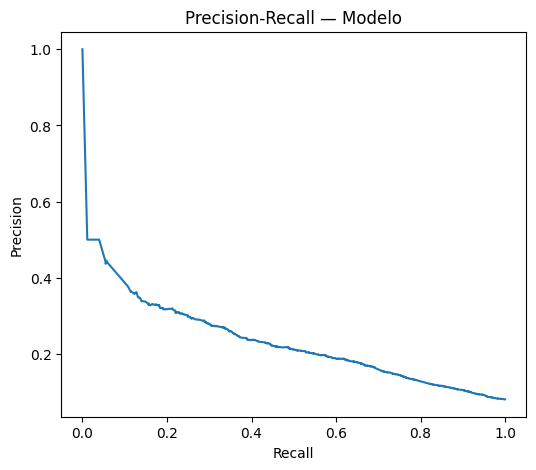

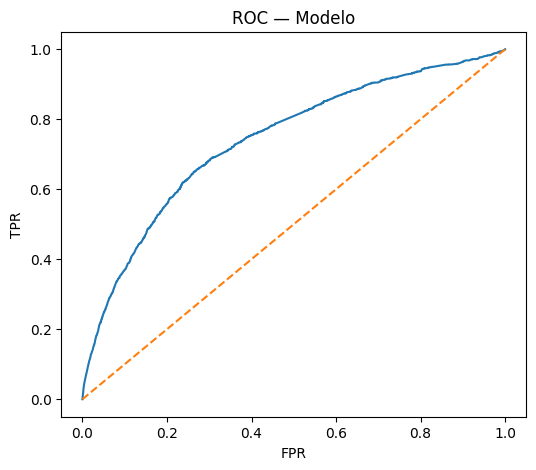

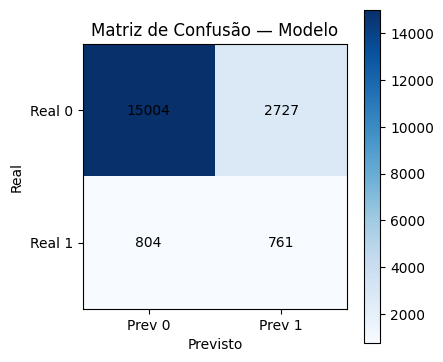

(0.12908311095002764,
 array([[15004,  2727],
        [  804,   761]]))

In [13]:
evaluate_model(y_test, y_prob)

In [14]:

def best_threshold_f1(y_true, y_prob):
    p, r, thr = precision_recall_curve(y_true, y_prob)
    # o vetor 'thr' tem len = len(p)-1 ; alinhar para F1 nos mesmos pontos
    f1 = 2 * p[:-1] * r[:-1] / (p[:-1] + r[:-1] + 1e-12)
    i = np.nanargmax(f1)
    return float(thr[i]), float(f1[i])

def best_threshold_min_cost(y_true, y_prob, cost_fp=1.0, cost_fn=5.0):
    # grid fino entre 0 e 1
    grid = np.linspace(0.01, 0.99, 99)
    y_true = np.asarray(y_true)
    costs = []
    for t in grid:
        y_hat = (y_prob >= t).astype(int)
        fp = ((y_hat == 1) & (y_true == 0)).sum()
        fn = ((y_hat == 0) & (y_true == 1)).sum()
        costs.append(cost_fp * fp + cost_fn * fn)
    idx = int(np.argmin(costs))
    return float(grid[idx]), float(costs[idx])

thr_f1, best_f1 = best_threshold_f1(y_test, y_prob)
thr_cost, best_cost = best_threshold_min_cost(y_test, y_prob, cost_fp=1.0, cost_fn=5.0)

print(f"thr_f1={thr_f1:.4f} (F1={best_f1:.4f})  |  thr_cost={thr_cost:.4f} (cost={best_cost:.1f})")



thr_f1=0.1291 (F1=0.3012)  |  thr_cost=0.1400 (cost=6695.0)


## 9. Importância de *features*

,feature,importance_split,importance_gain,importance
0,purchase_month,50,85198.708839,85198.708839
1,distance,56,21540.216530,21540.216530
2,customer_state,24,20088.695213,20088.695213
3,customer_zip_code_prefix,42,13952.813187,13952.813187
4,customer_city,17,12156.763931,12156.763931
5,sell_lat,51,10624.881897,10624.881897
6,cust_lat,51,10490.441528,10490.441528
7,freight_sum,43,10476.443298,10476.443298
8,seller_zip_code_prefix,35,10026.858620,10026.858620
9,sell_lng,49,9165.304798,9165.304798


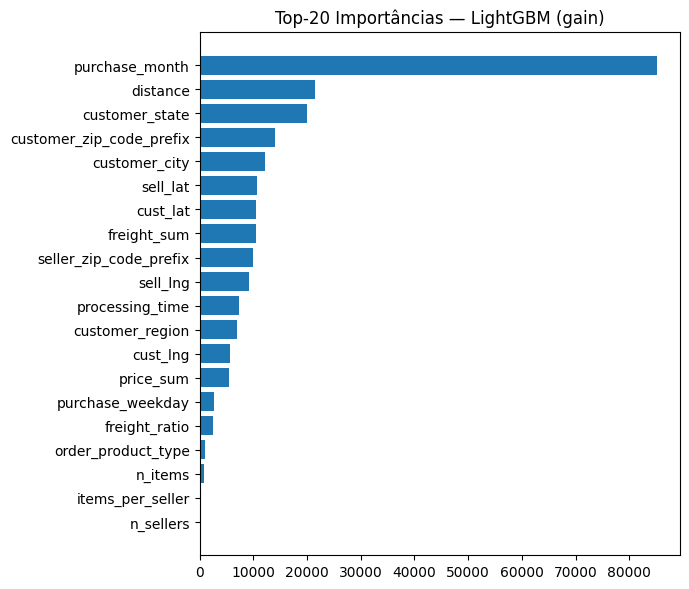

In [15]:
# Extrair importâncias do LightGBM (modelo scikit lgb.LGBMClassifier já treinado)
try:
    mdl = best_lgbm  # já é o estimator final (ex.: rs.best_estimator_)

    # Nomes das features: se você treinou com DataFrame, o LGBM guarda isso
    feat_names = getattr(mdl, "feature_name_", None)
    if feat_names is None:
        # fallback (ex.: se treinou com matriz numpy)
        feat_names = list(X_train_df.columns)

    # Dois tipos úteis de importância
    imp_split = mdl.booster_.feature_importance(importance_type="split")  # nº de vezes que a feature aparece em splits
    imp_gain  = mdl.booster_.feature_importance(importance_type="gain")   # ganho total (mais informativa)

    fi = (
        pd.DataFrame({
            "feature": feat_names,
            "importance_split": imp_split,
            "importance_gain": imp_gain
        })
        .assign(importance=lambda d: d["importance_gain"])   # escolha a métrica principal
        .sort_values("importance", ascending=False, ignore_index=True)
    )

    display(fi.head(25))

    # Plot Top-20 por GAIN (mais interpretável)
    topk = fi.head(20).iloc[::-1]  # invertido para barh crescer para cima
    plt.figure(figsize=(7, 6))
    plt.barh(range(len(topk)), topk["importance"].values)
    plt.yticks(range(len(topk)), topk["feature"].values)
    plt.title("Top-20 Importâncias — LightGBM (gain)")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Não foi possível extrair importâncias:", e)


## 10. Persistência do modelo e *helper* de inferência

In [16]:

ARTIFACT_DIR = "./artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# Salvar o pipeline completo + threshold escolhido
joblib.dump(best_lgbm, os.path.join(ARTIFACT_DIR, "xgb_pipeline.joblib"))
with open(os.path.join(ARTIFACT_DIR, "xgb_threshold.json"), "w") as f:
    json.dump({"threshold_f1": thr_f1, "threshold_cost": thr_cost}, f)

print("Artefatos salvos em:", ARTIFACT_DIR)

def predict_is_late_proba(df_new: pd.DataFrame, pipeline_path=os.path.join(ARTIFACT_DIR,"xgb_pipeline.joblib")):
    """Recebe um DataFrame no mesmo schema de features (pré-merge) e retorna probabilidade de atraso.
    
    Observação: para produção é recomendável extrair o mesmo pipeline de *feature engineering* usado acima.
    Aqui assume-se que df_new já passou pelos mesmos merges/engenharia e tem as colunas `feature_cols`.
    """
    pipe = joblib.load(pipeline_path)
    # Seleciona apenas as colunas esperadas (interseção para robustez)
    expected = [c for c in pipe.named_steps['pre'].get_feature_names_out()]  # nomes expandidos
    # Para simplificar, considere adaptar para aplicar o mesmo ColumnTransformer ao df_new original.
    raise NotImplementedError("Para produção, encapsule a etapa de engenharia + preprocessor antes do modelo.")


Artefatos salvos em: ./artifacts


## 11. Refinamento do Modelo

In [ ]:
# === 11.1 Feature engineering avançada ===
df_model['avg_item_price'] = df_model['price_sum'] / df_model['n_items']
df_model['avg_freight_item'] = df_model['freight_sum'] / df_model['n_items']

for c in ['avg_item_price','avg_freight_item']:
    df_model[c] = df_model[c].replace([np.inf,-np.inf], np.nan)

seller_state_map = (
    items.merge(sellers[['seller_id', 'seller_state']], on='seller_id', how='left')
         .groupby('order_id', as_index=False)['seller_state']
         .agg(lambda s: s.mode().iat[0] if not s.mode().empty else pd.NA)
         .rename(columns={'seller_state': 'seller_state_from_items'})
)

# 2) faz merge no df_model
# df_model = df_model.merge(seller_state_map, on='order_id', how='left')

if 'seller_state' in df_model.columns:
    src_col = 'seller_state'
elif 'seller_state_from_items' in df_model.columns:
    src_col = 'seller_state_from_items'
else:
    src_col = None

if src_col is None:
    # cria coluna vazia (tudo NA) para não quebrar o restante do fluxo
    df_model['seller_state'] = pd.Series(pd.NA, index=df_model.index, dtype='string')
else:
    df_model['seller_state'] = df_model[src_col].astype('string')

df_model['seller_region'] = df_model['seller_state'].map(state_to_region).astype('string')
df_model['same_state']   = (df_model['customer_state'] == df_model['seller_state']).astype('int8')
df_model['same_region']  = (df_model['customer_region'] == df_model['seller_region']).astype('int8')
cat_cols.extend(c for c in ['seller_state', 'seller_region', 'seller_state_from_items'] if c not in cat_cols and c in df_model.columns)
num_cols.extend(c for c in ['avg_item_price','avg_freight_item', 'same_state', 'same_region'] if c not in num_cols and c in df_model.columns)

# === 11.2 Montagem do dataset com novas features ===
cols_drop2 = [
    'is_late','order_id','customer_id',
    'order_purchase_timestamp','order_delivered_customer_date',
    'order_estimated_delivery_date','order_approved_at',
    'ship_deadline_max','shipping_limit_date','order_status',
    'seller_state_from_items_x', 'seller_state_from_items_y'
]
cols_drop2 = [c for c in cols_drop2 if c in df_model.columns]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


ValueError: Length of feature_name(34) and num_feature(375) don't match

In [ ]:
X2 = df_model.drop(columns=cols_drop2).copy()
y2 = df_model['is_late'].astype(int).copy()

bool_cols2 = X2.select_dtypes(include='boolean').columns
if len(bool_cols2) > 0:
    X2[bool_cols2] = X2[bool_cols2].astype('int8')

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.20, random_state=SEED, stratify=y2
)

X2_train_df = X2_train.copy()
X2_test_df = X2_test.copy()

imp_num = SimpleImputer(strategy='median')
X2_train_df[num_cols] = imp_num.fit_transform(X2_train_df[num_cols])
X2_test_df[num_cols]  = imp_num.transform(X2_test_df[num_cols])

for c in cat_cols:
    # 1) virar string e preencher NaN
    X2_train_df[c] = X2_train_df[c].astype('string').fillna('__missing__')
    X2_test_df[c]  = X2_test_df[c].astype('string').fillna('__missing__')
    X2_train_df[c], X2_test_df[c] = collapse_rare_train_test(X2_train_df[c], X2_test_df[c], min_count=50)


# sanity-check: nada de dtype string restante
bad = [c for c in X_train_df.columns if str(X2_train_df[c].dtype) == 'string']
assert not bad, f"Colunas com dtype string (não permitido no LGBM): {bad}"

# peso para desbalanceamento
spw = (y_train.value_counts()[0] / y_train.value_counts()[1])

# numeric_selector2 = selector(dtype_include=np.number)
# categorical_selector2 = selector(dtype_exclude=np.number)

num_tf2 = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])

cat_tf2 = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

pre2 = ColumnTransformer(
    transformers=[
        ('num', num_tf2, num_cols),
        ('cat', cat_tf2, cat_cols),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

# === 11.3 Treinamento do XGBoost aprimorado ===
pre2.fit(X2_train_df, y2_train)
Xtr = pre2.transform(X2_train_df)   # np.ndarray / scipy.sparse
Xte = pre2.transform(X2_test_df)

scale_pos_weight2 = (y2_train.value_counts()[0] / y2_train.value_counts()[1])

lgb_est = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    # device='cuda',          # habilite se quiser GPU
    n_jobs=1,                 # 1 ajuda a ver logs do LightGBM com clareza
    random_state=SEED,
    scale_pos_weight=scale_pos_weight2,
    verbose=-1,
    subsample_freq=1,
    force_row_wise=True,
    max_bin=510,
    deterministic=True
)

param_distributions2 = {
    # capacidade/forma da árvore
    'model__num_leaves'       : randint(64, 192),
    'model__max_depth'        : randint(6, 11),
    'model__min_child_samples': randint(20, 60),

    # amostragem
    'model__subsample'        : uniform(0.75, 0.25),
    'model__colsample_bytree' : uniform(0.75, 0.25),

    # regularização
    'model__reg_alpha'        : uniform(0.0, 0.10),
    'model__reg_lambda'       : uniform(0.0, 0.25),
    'model__min_split_gain'   : uniform(0.0, 0.05),

    # boosting
    'model__learning_rate'    : uniform(0.02, 0.06),
    'model__n_estimators'     : randint(600, 1400)
}

cv2 = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

rs2 = RandomizedSearchCV(
    estimator=lgb_est,
    param_distributions=param_distributions2,
    n_iter=50,
    scoring='average_precision',
    cv=cv2,
    n_jobs=1,
    pre_dispatch=1,
    verbose=3,
    random_state=SEED,
    refit=True,
    error_score='raise'
)
evals_result = {}
rs2.fit(
    Xtr, y2_train,
    eval_set=[(Xte, y2_test)],
    eval_metric=scorer,   # 'average_precision'
    callbacks=[
        lgb.log_evaluation(period=10),     # progresso a cada 10 iterações
        lgb.early_stopping(100, verbose=True),
        lgb.record_evaluation(evals_result)
    ],
)
best_lgbm2 = rs2.best_estimator_


print("Best params (LGBM):", rs2.best_params_)
print("Best CV AP (LGBM):", rs2.best_score_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.218084	valid_0's binary_logloss: 0.418075
[20]	valid_0's average_precision: 0.234607	valid_0's binary_logloss: 0.504023
[30]	valid_0's average_precision: 0.240433	valid_0's binary_logloss: 0.534457
[40]	valid_0's average_precision: 0.243632	valid_0's binary_logloss: 0.539327
[50]	valid_0's average_precision: 0.24372	valid_0's binary_logloss: 0.536507
[60]	valid_0's average_precision: 0.24478	valid_0's binary_logloss: 0.530783
[70]	valid_0's average_precision: 0.243112	valid_0's binary_logloss: 0.525505
[80]	valid_0's average_precision: 0.245134	valid_0's binary_logloss: 0.519935
[90]	valid_0's average_precision: 0.244913	valid_0's binary_logloss: 0.514285
[100]	valid_0's average_precision: 0.246083	valid_0's binary_logloss: 0.509401
Did not meet early stopping. Best iteration is:
[99]	valid_0's average_precision: 0.246752	valid_0's binary_logloss: 0.509808
[CV 1/3] END model__colsample_byt

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.231886	valid_0's binary_logloss: 0.418751
[20]	valid_0's average_precision: 0.238412	valid_0's binary_logloss: 0.503758
[30]	valid_0's average_precision: 0.242686	valid_0's binary_logloss: 0.533887
[40]	valid_0's average_precision: 0.250237	valid_0's binary_logloss: 0.53921
[50]	valid_0's average_precision: 0.252618	valid_0's binary_logloss: 0.536227
[60]	valid_0's average_precision: 0.253307	valid_0's binary_logloss: 0.531364
[70]	valid_0's average_precision: 0.255382	valid_0's binary_logloss: 0.526196
[80]	valid_0's average_precision: 0.255415	valid_0's binary_logloss: 0.52064
[90]	valid_0's average_precision: 0.25267	valid_0's binary_logloss: 0.515285
[100]	valid_0's average_precision: 0.2519	valid_0's binary_logloss: 0.510306
Did not meet early stopping. Best iteration is:
[69]	valid_0's average_precision: 0.255755	valid_0's binary_logloss: 0.526551
[CV 2/3] END model__colsample_bytree

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.234038	valid_0's binary_logloss: 0.41845
[20]	valid_0's average_precision: 0.242994	valid_0's binary_logloss: 0.504668
[30]	valid_0's average_precision: 0.250401	valid_0's binary_logloss: 0.534051
[40]	valid_0's average_precision: 0.252957	valid_0's binary_logloss: 0.540432
[50]	valid_0's average_precision: 0.257745	valid_0's binary_logloss: 0.538132
[60]	valid_0's average_precision: 0.258765	valid_0's binary_logloss: 0.532911
[70]	valid_0's average_precision: 0.257579	valid_0's binary_logloss: 0.527022
[80]	valid_0's average_precision: 0.256598	valid_0's binary_logloss: 0.521753
[90]	valid_0's average_precision: 0.254916	valid_0's binary_logloss: 0.51623
[100]	valid_0's average_precision: 0.255022	valid_0's binary_logloss: 0.511126
Did not meet early stopping. Best iteration is:
[59]	valid_0's average_precision: 0.258837	valid_0's binary_logloss: 0.5336
[CV 3/3] END model__colsample_bytre

/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[10]	valid_0's average_precision: 0.237606	valid_0's binary_logloss: 0.42001
[20]	valid_0's average_precision: 0.248269	valid_0's binary_logloss: 0.507052
[30]	valid_0's average_precision: 0.255312	valid_0's binary_logloss: 0.538837
[40]	valid_0's average_precision: 0.257189	valid_0's binary_logloss: 0.546537
[50]	valid_0's average_precision: 0.259487	valid_0's binary_logloss: 0.545274
[60]	valid_0's average_precision: 0.261828	valid_0's binary_logloss: 0.541687
[70]	valid_0's average_precision: 0.262467	valid_0's binary_logloss: 0.537151
[80]	valid_0's average_precision: 0.262167	valid_0's binary_logloss: 0.532931
[90]	valid_0's average_precision: 0.26164	valid_0's binary_logloss: 0.529282
[100]	valid_0's average_precision: 0.262875	valid_0's binary_logloss: 0.52513
Did not meet early stopping. Best iteration is:
[98]	valid_0's average_precision: 0.263441	valid_0's binary_logloss: 0.526043
Best params (LGBM): {'model__colsa

[Modelo] Threshold=0.610 | ROC-AUC=0.773 | PR-AUC=0.263
              precision    recall  f1-score   support

           0      0.951     0.870     0.909     17731
           1      0.251     0.493     0.332      1565

    accuracy                          0.840     19296
   macro avg      0.601     0.681     0.621     19296
weighted avg      0.894     0.840     0.862     19296



/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


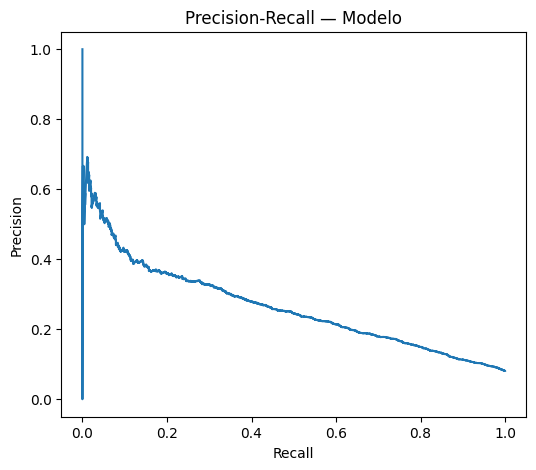

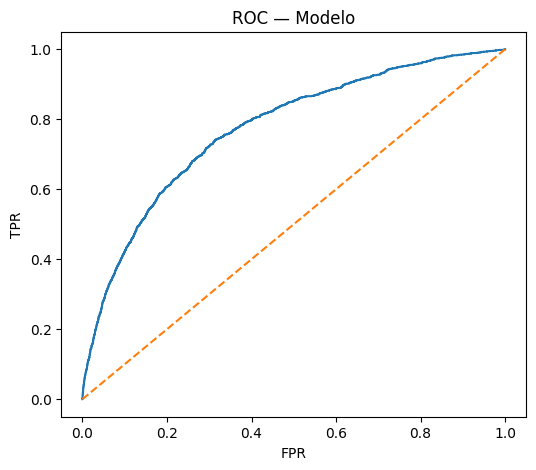

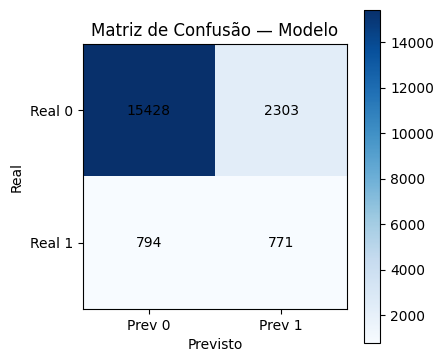

(0.6097611574612042,
 array([[15428,  2303],
        [  794,   771]]))

In [ ]:
# === 11.4 Avaliação no teste ===
y2_prob = best_lgbm2.predict_proba(Xte)[:, 1]
thr2, p_best2, r_best2, f1_best2 = best_threshold_by_f1(y2_test, y2_prob)
# row_lgbm = {
#     'model': 'XGB',
#     'threshold*': thr2,
#     'F1@thr*': f1_best2,
#     'Precision@thr*': p_best2,
#     'Recall@thr*': r_best2,
#     'PR-AUC': average_precision_score(y2_test, y2_prob),
#     'ROC-AUC': roc_auc_score(y2_test, y2_prob)
# }

evaluate_model(y2_test, y2_prob)

,feature,importance_split,importance_gain,importance
0,Column_6,270,80477.472144,80477.472144
1,Column_5,164,19475.735456,19475.735456
2,Column_24,159,17851.213070,17851.213070
3,Column_14,172,17655.346686,17655.346686
4,Column_22,162,15360.815802,15360.815802
5,Column_4,218,14808.094748,14808.094748
6,Column_15,149,13772.989257,13772.989257
7,Column_16,187,12803.906803,12803.906803
8,Column_13,166,12675.544527,12675.544527
9,Column_17,173,11622.511026,11622.511026


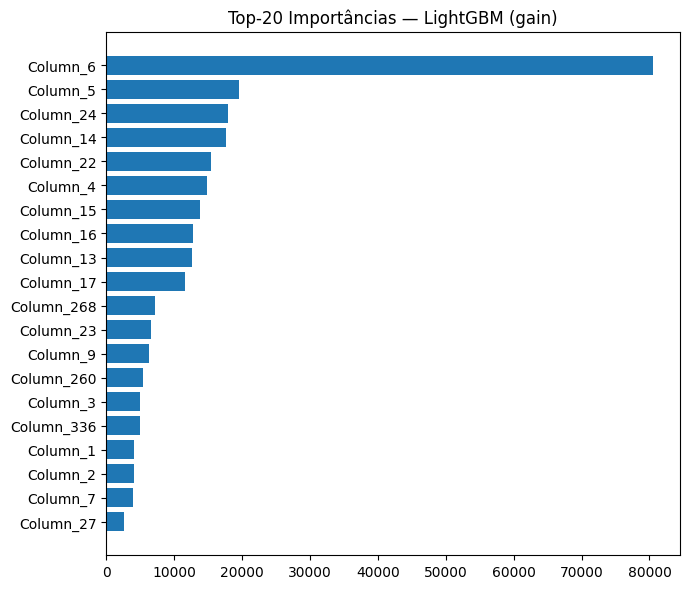

In [37]:
# Extrair importâncias do LightGBM (modelo scikit lgb.LGBMClassifier já treinado)
try:
    mdl = best_lgbm2  # já é o estimator final (ex.: rs.best_estimator_)

    # Nomes das features: se você treinou com DataFrame, o LGBM guarda isso
    feat_names = getattr(mdl, "feature_name_", None)
    if feat_names is None:
        # fallback (ex.: se treinou com matriz numpy)
        feat_names = list(df_model.drop(columns=cols_drop2).columns)

    # Dois tipos úteis de importância
    imp_split = mdl.booster_.feature_importance(importance_type="split")  # nº de vezes que a feature aparece em splits
    imp_gain  = mdl.booster_.feature_importance(importance_type="gain")   # ganho total (mais informativa)

    fi = (
        pd.DataFrame({
            "feature": feat_names,
            "importance_split": imp_split,
            "importance_gain": imp_gain
        })
        .assign(importance=lambda d: d["importance_gain"])   # escolha a métrica principal
        .sort_values("importance", ascending=False, ignore_index=True)
    )

    display(fi.head(25))

    # Plot Top-20 por GAIN (mais interpretável)
    topk = fi.head(20).iloc[::-1]  # invertido para barh crescer para cima
    plt.figure(figsize=(7, 6))
    plt.barh(range(len(topk)), topk["importance"].values)
    plt.yticks(range(len(topk)), topk["feature"].values)
    plt.title("Top-20 Importâncias — LightGBM (gain)")
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("Não foi possível extrair importâncias:", e)



## 12. Tuning com Optuna (XGBoost) — PR-AUC

Nesta seção usa-se **Optuna** para buscar hiperparâmetros do **XGBoost** maximizando **PR-AUC** (métrica indicada para classe desbalanceada).  
O código é **defensivo**: caso `optuna` não esteja instalado, exibe-se instruções para instalação e a célula segue sem travar.

**Observações importantes**:
- Usa-se `StratifiedKFold(n_splits=3)` para validação.
- Espaço de busca prioriza *learning rate* menor e mais árvores (melhor para classe rara).
- Após encontrar os melhores hiperparâmetros, re-treina no *train* completo e avalia no *test* com **threshold ótimo por F1** e também por **custo**.

In [40]:

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
pre_auto = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imp', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler(with_mean=False)),
        ]), selector(dtype_include=np.number)),
        ('cat', Pipeline([
            ('imp', SimpleImputer(strategy='most_frequent')),
            ('ohe', OneHotEncoder(handle_unknown='ignore')),
        ]), selector(dtype_exclude=np.number)),
    ],
    remainder='drop',
    verbose_feature_names_out=False,
)

DATA_X, DATA_y = X2, y2
PRE = pre_auto  # ou pre2, dependendo de como você chamou seu ColumnTransformer
spw = (DATA_y.value_counts()[0] / DATA_y.value_counts()[1])

# ====== OPTUNA ======
try:
    import optuna
    has_optuna = True
except Exception:
    has_optuna = False
    print("[Aviso] optuna não está disponível. Instale com: pip install optuna")

if has_optuna:

    def build_pipe(trial):
        params = dict(
            objective='binary',
            boosting_type='gbdt',
            # device='cuda',  # ative se o seu build GPU estiver estável
            n_estimators=trial.suggest_int('n_estimators', 800, 1400, step=100),
            learning_rate=trial.suggest_float('learning_rate', 0.025, 0.06),
            num_leaves=trial.suggest_int('num_leaves', 64, 160),
            max_depth=trial.suggest_int('max_depth', 6, 10),
            min_child_samples=trial.suggest_int('min_child_samples', 20, 60),
            subsample=trial.suggest_float('subsample', 0.75, 1.0),
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.75, 1.0),
            reg_lambda=trial.suggest_float('reg_lambda', 1e-3, 5.0, log=True),
            reg_alpha=trial.suggest_float('reg_alpha', 1e-3, 1.0, log=True),
            min_split_gain=trial.suggest_float('min_split_gain', 0.0, 0.03),
            subsample_freq=1,
            max_bin=510,
            deterministic=True,
            n_jobs=1,              # <- evita oversubscription
            random_state=42,
            scale_pos_weight=spw,
            verbose=-1,
            metric='aucpr',
            force_row_wise=True
        )
        model = lgb.LGBMClassifier(**params)
        # cacheia o pre (acelera CV)
        return Pipeline(steps=[('pre', PRE), ('model', model)],
                    memory=joblib.Memory(location="./.sk_cache", verbose=0))

    scorer = 'average_precision'  # PR-AUC em cross_val_score

    def objective(trial):
        pipe = build_pipe(trial)
        # n_jobs=1 aqui para não abrir mil processos
        scores = cross_val_score(pipe, DATA_X, DATA_y, scoring=scorer, cv=cv, n_jobs=1, error_score='raise')
        return float(scores.mean())

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30, show_progress_bar=True, n_jobs=1)  # n_jobs=1 = trials sequenciais


    print("Melhor PR-AUC (CV):", study.best_value)
    print("Melhores parâmetros:", study.best_params)

    # ====== REFIT COM MELHOR CONJUNTO ======
    best_pipe = build_pipe(optuna.trial.FixedTrial(study.best_params))
    best_pipe.fit(X2_train, y2_train)

    # ====== AVALIAÇÃO NO TESTE ======
    y_prob_opt = best_pipe.predict_proba(X2_test)[:, 1]

    thr_f1, p_best, r_best, f1_best = best_threshold_by_f1(y2_test, y_prob_opt)
    print(f"[Optuna LGBM] Threshold@F1={thr_f1:.3f} | F1={f1_best:.3f} | "
           f"Precision={p_best:.3f} | Recall={r_best:.3f}")
    # print("ROC-AUC:", roc_auc_score(y2_test, y_prob_opt))
    # print("PR-AUC :", average_precision_score(y2_test, y_prob_opt))

    # # Curva PR
    # prec, rec, _ = precision_recall_curve(y2_test, y_prob_opt)
    # plt.figure(figsize=(6,5))
    # plt.plot(rec, prec)
    # plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR Curve — LGBM (Optuna best)")
    # plt.tight_layout()
    # plt.show()

    # Threshold ótimo por custo (ex.: FN custa 5× FP)
    thr_cost, min_cost = threshold_by_cost(y2_test, y_prob_opt, cost_fp=1.0, cost_fn=5.0)
    print(f"[CUSTO] threshold={thr_cost:.3f} | custo mínimo={min_cost:.2f}")

else:
    print("[Skip] Seção Optuna ignorada (instale optuna para habilitar).")

[I 2025-09-07 16:33:04,759] A new study created in memory with name: no-name-7eb99ba5-f94f-4b38-b5d1-a23cd5865ae1
  0%|          | 0/30 [00:00<?, ?it/s]/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 0. Best value: 0.267755:   3%|▎         | 1/30 [00:42<20:19, 42.04s/it]

[I 2025-09-07 16:33:46,801] Trial 0 finished with value: 0.2677547087614726 and parameters: {'n_estimators': 1200, 'learning_rate': 0.04671543525426255, 'num_leaves': 92, 'max_depth': 8, 'min_child_samples': 47, 'subsample': 0.8931794481592154, 'colsample_bytree': 0.9116556204448028, 'reg_lambda': 0.006161529528100381, 'reg_alpha': 0.19276163853227934, 'min_split_gain': 0.006040561990711574}. Best is trial 0 with value: 0.2677547087614726.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 0. Best value: 0.267755:   7%|▋         | 2/30 [01:23<19:31, 41.84s/it]

[I 2025-09-07 16:34:28,497] Trial 1 finished with value: 0.2656135876264005 and parameters: {'n_estimators': 1200, 'learning_rate': 0.051211803158675406, 'num_leaves': 140, 'max_depth': 8, 'min_child_samples': 52, 'subsample': 0.8601771170805408, 'colsample_bytree': 0.9888679047085465, 'reg_lambda': 0.04983737606181839, 'reg_alpha': 0.003953508082532949, 'min_split_gain': 0.01051820328047312}. Best is trial 0 with value: 0.2677547087614726.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 2. Best value: 0.271465:  10%|█         | 3/30 [01:54<16:30, 36.68s/it]

[I 2025-09-07 16:34:59,030] Trial 2 finished with value: 0.27146477991474055 and parameters: {'n_estimators': 1200, 'learning_rate': 0.04458800026288412, 'num_leaves': 132, 'max_depth': 6, 'min_child_samples': 55, 'subsample': 0.9318873784149602, 'colsample_bytree': 0.9833949450411411, 'reg_lambda': 1.0821095771620655, 'reg_alpha': 0.06839150198559758, 'min_split_gain': 0.0046263263859799295}. Best is trial 2 with value: 0.27146477991474055.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 2. Best value: 0.271465:  13%|█▎        | 4/30 [02:43<17:59, 41.52s/it]

[I 2025-09-07 16:35:47,967] Trial 3 finished with value: 0.2631101434622274 and parameters: {'n_estimators': 1100, 'learning_rate': 0.04595108845382906, 'num_leaves': 124, 'max_depth': 10, 'min_child_samples': 41, 'subsample': 0.8053120644454589, 'colsample_bytree': 0.934293460832447, 'reg_lambda': 0.008550220424327168, 'reg_alpha': 0.0021167840467515514, 'min_split_gain': 0.005803102804224117}. Best is trial 2 with value: 0.27146477991474055.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 2. Best value: 0.271465:  17%|█▋        | 5/30 [03:10<15:13, 36.52s/it]

[I 2025-09-07 16:36:15,632] Trial 4 finished with value: 0.2701107603870924 and parameters: {'n_estimators': 1100, 'learning_rate': 0.05291632162707341, 'num_leaves': 140, 'max_depth': 6, 'min_child_samples': 33, 'subsample': 0.9040525155702694, 'colsample_bytree': 0.7904426617924039, 'reg_lambda': 0.11929907630265528, 'reg_alpha': 0.31033803924586584, 'min_split_gain': 0.022312819708648762}. Best is trial 2 with value: 0.27146477991474055.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 5. Best value: 0.274202:  20%|██        | 6/30 [03:39<13:29, 33.71s/it]

[I 2025-09-07 16:36:43,885] Trial 5 finished with value: 0.27420208219347436 and parameters: {'n_estimators': 800, 'learning_rate': 0.04597497069085788, 'num_leaves': 144, 'max_depth': 8, 'min_child_samples': 33, 'subsample': 0.7991455355496855, 'colsample_bytree': 0.7577481696204826, 'reg_lambda': 4.774270487378022, 'reg_alpha': 0.0039813396215850885, 'min_split_gain': 0.008608650475766179}. Best is trial 5 with value: 0.27420208219347436.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 5. Best value: 0.274202:  23%|██▎       | 7/30 [04:11<12:45, 33.27s/it]

[I 2025-09-07 16:37:16,259] Trial 6 finished with value: 0.2643394886108432 and parameters: {'n_estimators': 1000, 'learning_rate': 0.0591282462818921, 'num_leaves': 74, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.9491681505426532, 'colsample_bytree': 0.9007806878675978, 'reg_lambda': 0.0751426459612511, 'reg_alpha': 0.010687933925222408, 'min_split_gain': 0.009658442668320544}. Best is trial 5 with value: 0.27420208219347436.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 5. Best value: 0.274202:  27%|██▋       | 8/30 [04:42<11:59, 32.69s/it]

[I 2025-09-07 16:37:47,715] Trial 7 finished with value: 0.2651033136722683 and parameters: {'n_estimators': 800, 'learning_rate': 0.05478990137354392, 'num_leaves': 98, 'max_depth': 9, 'min_child_samples': 27, 'subsample': 0.8777298197037939, 'colsample_bytree': 0.8766939102501735, 'reg_lambda': 0.0010388044460607694, 'reg_alpha': 0.47688249621337336, 'min_split_gain': 0.008414121896688406}. Best is trial 5 with value: 0.27420208219347436.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 5. Best value: 0.274202:  30%|███       | 9/30 [05:33<13:26, 38.39s/it]

[I 2025-09-07 16:38:38,622] Trial 8 finished with value: 0.26118497357230835 and parameters: {'n_estimators': 1400, 'learning_rate': 0.05971763885497069, 'num_leaves': 149, 'max_depth': 9, 'min_child_samples': 38, 'subsample': 0.9443085398968472, 'colsample_bytree': 0.7936212341532145, 'reg_lambda': 0.004661231448679357, 'reg_alpha': 0.03937010416567186, 'min_split_gain': 0.028521139527173875}. Best is trial 5 with value: 0.27420208219347436.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 9. Best value: 0.274671:  33%|███▎      | 10/30 [06:07<12:17, 36.87s/it]

[I 2025-09-07 16:39:12,103] Trial 9 finished with value: 0.27467069629577295 and parameters: {'n_estimators': 1000, 'learning_rate': 0.035241208107634606, 'num_leaves': 149, 'max_depth': 8, 'min_child_samples': 30, 'subsample': 0.9065910291820652, 'colsample_bytree': 0.7555133614572598, 'reg_lambda': 0.5921255513894653, 'reg_alpha': 0.5511292390438213, 'min_split_gain': 0.015406810971213384}. Best is trial 9 with value: 0.27467069629577295.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 9. Best value: 0.274671:  37%|███▋      | 11/30 [06:33<10:36, 33.50s/it]

[I 2025-09-07 16:39:37,950] Trial 10 finished with value: 0.2722981713145032 and parameters: {'n_estimators': 900, 'learning_rate': 0.0316046999875982, 'num_leaves': 159, 'max_depth': 7, 'min_child_samples': 20, 'subsample': 0.9790223062896057, 'colsample_bytree': 0.8333874449665251, 'reg_lambda': 0.6299113375400096, 'reg_alpha': 0.9923276197299608, 'min_split_gain': 0.01752470109483417}. Best is trial 9 with value: 0.27467069629577295.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 11. Best value: 0.276363:  40%|████      | 12/30 [06:57<09:13, 30.77s/it]

[I 2025-09-07 16:40:02,477] Trial 11 finished with value: 0.2763626736834297 and parameters: {'n_estimators': 800, 'learning_rate': 0.03491874130862209, 'num_leaves': 117, 'max_depth': 7, 'min_child_samples': 30, 'subsample': 0.7638364945522923, 'colsample_bytree': 0.7505540005099411, 'reg_lambda': 4.246790285011193, 'reg_alpha': 0.011493758470717916, 'min_split_gain': 0.00014171434478649908}. Best is trial 11 with value: 0.2763626736834297.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 11. Best value: 0.276363:  43%|████▎     | 13/30 [07:25<08:26, 29.80s/it]

[I 2025-09-07 16:40:30,030] Trial 12 finished with value: 0.2741997370108567 and parameters: {'n_estimators': 900, 'learning_rate': 0.03415230746437066, 'num_leaves': 117, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.7596343105733727, 'colsample_bytree': 0.7512275390531017, 'reg_lambda': 4.594935398225545, 'reg_alpha': 0.015434644892917964, 'min_split_gain': 0.00020505444723805728}. Best is trial 11 with value: 0.2763626736834297.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 11. Best value: 0.276363:  47%|████▋     | 14/30 [07:52<07:44, 29.02s/it]

[I 2025-09-07 16:40:57,264] Trial 13 finished with value: 0.27481063012015683 and parameters: {'n_estimators': 900, 'learning_rate': 0.02576945238998756, 'num_leaves': 100, 'max_depth': 7, 'min_child_samples': 28, 'subsample': 0.838889633093159, 'colsample_bytree': 0.8193651800692935, 'reg_lambda': 0.5590297435240542, 'reg_alpha': 0.09574907716206861, 'min_split_gain': 0.016204102326611892}. Best is trial 11 with value: 0.2763626736834297.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 14. Best value: 0.277624:  50%|█████     | 15/30 [08:17<06:55, 27.69s/it]

[I 2025-09-07 16:41:21,874] Trial 14 finished with value: 0.2776235194978381 and parameters: {'n_estimators': 800, 'learning_rate': 0.02520435162748643, 'num_leaves': 94, 'max_depth': 7, 'min_child_samples': 40, 'subsample': 0.836330792242865, 'colsample_bytree': 0.8314327141747089, 'reg_lambda': 1.3997098929870606, 'reg_alpha': 0.07131745429872191, 'min_split_gain': 0.0202159442938942}. Best is trial 14 with value: 0.2776235194978381.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 14. Best value: 0.277624:  53%|█████▎    | 16/30 [08:38<06:02, 25.88s/it]

[I 2025-09-07 16:41:43,535] Trial 15 finished with value: 0.27234757122158626 and parameters: {'n_estimators': 800, 'learning_rate': 0.02620088476853284, 'num_leaves': 78, 'max_depth': 6, 'min_child_samples': 42, 'subsample': 0.7589580648152607, 'colsample_bytree': 0.8530797393767993, 'reg_lambda': 1.8344326367771895, 'reg_alpha': 0.01711447189304971, 'min_split_gain': 0.02218051731529554}. Best is trial 14 with value: 0.2776235194978381.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 14. Best value: 0.277624:  57%|█████▋    | 17/30 [09:19<06:34, 30.33s/it]

[I 2025-09-07 16:42:24,207] Trial 16 finished with value: 0.2744490798252588 and parameters: {'n_estimators': 1400, 'learning_rate': 0.029878021338989227, 'num_leaves': 111, 'max_depth': 7, 'min_child_samples': 60, 'subsample': 0.8063079994505064, 'colsample_bytree': 0.8000526257121271, 'reg_lambda': 0.20229329558871817, 'reg_alpha': 0.03730996977346328, 'min_split_gain': 0.021518370990840377}. Best is trial 14 with value: 0.2776235194978381.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 14. Best value: 0.277624:  60%|██████    | 18/30 [09:43<05:42, 28.53s/it]

[I 2025-09-07 16:42:48,557] Trial 17 finished with value: 0.2754416843973098 and parameters: {'n_estimators': 800, 'learning_rate': 0.03919471287910083, 'num_leaves': 64, 'max_depth': 7, 'min_child_samples': 37, 'subsample': 0.8422139960569125, 'colsample_bytree': 0.8568200716353039, 'reg_lambda': 1.9952981286090474, 'reg_alpha': 0.001160035258750487, 'min_split_gain': 0.028712323815294295}. Best is trial 14 with value: 0.2776235194978381.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 14. Best value: 0.277624:  63%|██████▎   | 19/30 [10:22<05:47, 31.58s/it]

[I 2025-09-07 16:43:27,252] Trial 18 finished with value: 0.2690205329792334 and parameters: {'n_estimators': 1000, 'learning_rate': 0.040363714484205906, 'num_leaves': 105, 'max_depth': 9, 'min_child_samples': 45, 'subsample': 0.7848157192507452, 'colsample_bytree': 0.8204089950161694, 'reg_lambda': 0.2813737989774611, 'reg_alpha': 0.009100738990173024, 'min_split_gain': 0.012575612407015777}. Best is trial 14 with value: 0.2776235194978381.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 14. Best value: 0.277624:  67%|██████▋   | 20/30 [10:45<04:51, 29.11s/it]

[I 2025-09-07 16:43:50,615] Trial 19 finished with value: 0.2711268493163279 and parameters: {'n_estimators': 900, 'learning_rate': 0.03726856908775195, 'num_leaves': 88, 'max_depth': 6, 'min_child_samples': 24, 'subsample': 0.7762344740606337, 'colsample_bytree': 0.7809678937400093, 'reg_lambda': 0.026414965957334984, 'reg_alpha': 0.07867904557237795, 'min_split_gain': 0.00013951179507702883}. Best is trial 14 with value: 0.2776235194978381.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 14. Best value: 0.277624:  70%|███████   | 21/30 [11:25<04:49, 32.15s/it]

[I 2025-09-07 16:44:29,856] Trial 20 finished with value: 0.2738397597259415 and parameters: {'n_estimators': 1300, 'learning_rate': 0.02957514587156937, 'num_leaves': 122, 'max_depth': 7, 'min_child_samples': 35, 'subsample': 0.8266580903052633, 'colsample_bytree': 0.932832820937033, 'reg_lambda': 1.987222897729436, 'reg_alpha': 0.14878365348777053, 'min_split_gain': 0.01944305468279342}. Best is trial 14 with value: 0.2776235194978381.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 14. Best value: 0.277624:  73%|███████▎  | 22/30 [11:49<03:58, 29.85s/it]

[I 2025-09-07 16:44:54,318] Trial 21 finished with value: 0.27562205502728254 and parameters: {'n_estimators': 800, 'learning_rate': 0.03937010585396322, 'num_leaves': 65, 'max_depth': 7, 'min_child_samples': 37, 'subsample': 0.8427005910692861, 'colsample_bytree': 0.8639890988308406, 'reg_lambda': 2.054554022860509, 'reg_alpha': 0.001008630008861405, 'min_split_gain': 0.029992081719121714}. Best is trial 14 with value: 0.2776235194978381.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 14. Best value: 0.277624:  77%|███████▋  | 23/30 [12:14<03:17, 28.25s/it]

[I 2025-09-07 16:45:18,844] Trial 22 finished with value: 0.2763223991087212 and parameters: {'n_estimators': 800, 'learning_rate': 0.04186015355604705, 'num_leaves': 83, 'max_depth': 7, 'min_child_samples': 46, 'subsample': 0.8618037475212901, 'colsample_bytree': 0.8671622567494441, 'reg_lambda': 2.9638866767456977, 'reg_alpha': 0.005857636886136301, 'min_split_gain': 0.025517511346758538}. Best is trial 14 with value: 0.2776235194978381.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 14. Best value: 0.277624:  80%|████████  | 24/30 [12:38<02:41, 26.98s/it]

[I 2025-09-07 16:45:42,873] Trial 23 finished with value: 0.27322894447852913 and parameters: {'n_estimators': 900, 'learning_rate': 0.042244264968458976, 'num_leaves': 83, 'max_depth': 6, 'min_child_samples': 48, 'subsample': 0.8644185486456477, 'colsample_bytree': 0.9010052198541474, 'reg_lambda': 2.979102464763239, 'reg_alpha': 0.004960371635467096, 'min_split_gain': 0.025182089891573976}. Best is trial 14 with value: 0.2776235194978381.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 14. Best value: 0.277624:  83%|████████▎ | 25/30 [13:02<02:11, 26.24s/it]

[I 2025-09-07 16:46:07,385] Trial 24 finished with value: 0.27462662460682713 and parameters: {'n_estimators': 800, 'learning_rate': 0.03434250321258858, 'num_leaves': 110, 'max_depth': 7, 'min_child_samples': 44, 'subsample': 0.8203545233788334, 'colsample_bytree': 0.8366674757719137, 'reg_lambda': 0.9370433445506761, 'reg_alpha': 0.02475722044749365, 'min_split_gain': 0.024262121244121547}. Best is trial 14 with value: 0.2776235194978381.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 14. Best value: 0.277624:  87%|████████▋ | 26/30 [13:36<01:54, 28.51s/it]

[I 2025-09-07 16:46:41,203] Trial 25 finished with value: 0.2767133405926548 and parameters: {'n_estimators': 1000, 'learning_rate': 0.028699138674679103, 'num_leaves': 94, 'max_depth': 8, 'min_child_samples': 51, 'subsample': 0.8815769420854342, 'colsample_bytree': 0.8893367864088102, 'reg_lambda': 0.3616186746882301, 'reg_alpha': 0.008701963890057939, 'min_split_gain': 0.02568407936147514}. Best is trial 14 with value: 0.2776235194978381.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 14. Best value: 0.277624:  90%|█████████ | 27/30 [14:10<01:30, 30.04s/it]

[I 2025-09-07 16:47:14,801] Trial 26 finished with value: 0.27648526792507094 and parameters: {'n_estimators': 1000, 'learning_rate': 0.02846106886443685, 'num_leaves': 96, 'max_depth': 8, 'min_child_samples': 52, 'subsample': 0.9198251796248245, 'colsample_bytree': 0.953042809985267, 'reg_lambda': 0.2819686045262767, 'reg_alpha': 0.04643639250068053, 'min_split_gain': 0.019450751328532957}. Best is trial 14 with value: 0.2776235194978381.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 14. Best value: 0.277624:  93%|█████████▎| 28/30 [14:47<01:04, 32.19s/it]

[I 2025-09-07 16:47:51,995] Trial 27 finished with value: 0.2771406469834517 and parameters: {'n_estimators': 1000, 'learning_rate': 0.028396954411137765, 'num_leaves': 95, 'max_depth': 9, 'min_child_samples': 53, 'subsample': 0.9252316941128179, 'colsample_bytree': 0.960326439052814, 'reg_lambda': 0.29635591676349715, 'reg_alpha': 0.05234138365673662, 'min_split_gain': 0.01799488320538987}. Best is trial 14 with value: 0.2776235194978381.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 14. Best value: 0.277624:  97%|█████████▋| 29/30 [15:30<00:35, 35.61s/it]

[I 2025-09-07 16:48:35,607] Trial 28 finished with value: 0.27305172205975736 and parameters: {'n_estimators': 1100, 'learning_rate': 0.027162357470367694, 'num_leaves': 104, 'max_depth': 10, 'min_child_samples': 60, 'subsample': 0.974280512213733, 'colsample_bytree': 0.9671853393287866, 'reg_lambda': 0.14188148229967615, 'reg_alpha': 0.02074996429467952, 'min_split_gain': 0.019465476178109984}. Best is trial 14 with value: 0.2776235194978381.


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
Best trial: 14. Best value: 0.277624: 100%|██████████| 30/30 [16:15<00:00, 32.51s/it]


[I 2025-09-07 16:49:20,055] Trial 29 finished with value: 0.27214354901729515 and parameters: {'n_estimators': 1200, 'learning_rate': 0.031446283878550786, 'num_leaves': 91, 'max_depth': 9, 'min_child_samples': 49, 'subsample': 0.8861005354965639, 'colsample_bytree': 0.8910394403875392, 'reg_lambda': 0.3558493164679168, 'reg_alpha': 0.15828192652921452, 'min_split_gain': 0.013174120107231112}. Best is trial 14 with value: 0.2776235194978381.
Melhor PR-AUC (CV): 0.2776235194978381
Melhores parâmetros: {'n_estimators': 800, 'learning_rate': 0.02520435162748643, 'num_leaves': 94, 'max_depth': 7, 'min_child_samples': 40, 'subsample': 0.836330792242865, 'colsample_bytree': 0.8314327141747089, 'reg_lambda': 1.3997098929870606, 'reg_alpha': 0.07131745429872191, 'min_split_gain': 0.0202159442938942}


/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[Optuna LGBM] Threshold@F1=0.614 | F1=0.341 | Precision=0.271 | Recall=0.460
[CUSTO] threshold=0.570 | custo mínimo=6177.00


[LightGBM - Optuna] Threshold=0.614 | ROC-AUC=0.780 | PR-AUC=0.277
              precision    recall  f1-score   support

           0      0.949     0.891     0.919     17731
           1      0.271     0.460     0.341      1565

    accuracy                          0.856     19296
   macro avg      0.610     0.675     0.630     19296
weighted avg      0.894     0.856     0.872     19296



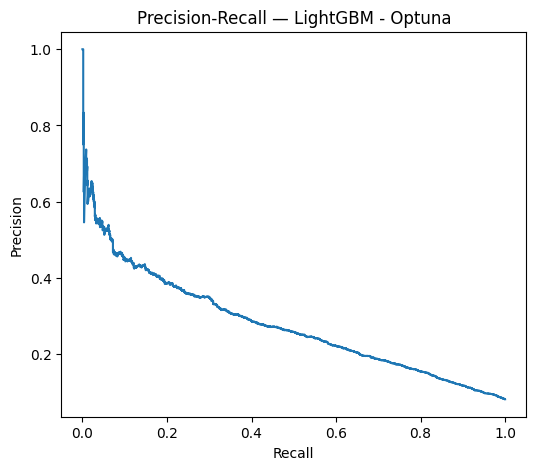

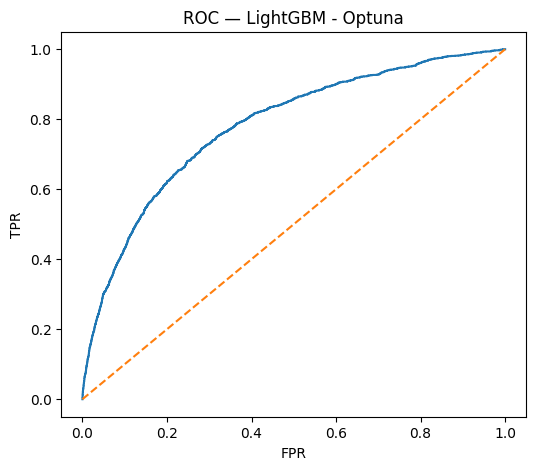

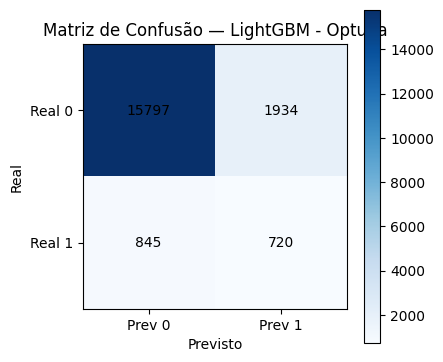

(0.6141573564844623,
 array([[15797,  1934],
        [  845,   720]]))

In [42]:
evaluate_model(y2_test, y_prob_opt, label="LightGBM - Optuna")


## 13. Resumo Executivo & Insights de Negócio

**Objetivo de negócio:** reduzir atrasos de entrega identificando **pedidos de alto risco** com antecedência.

### Principais achados
- O modelo baseado em **gradient boosting** (XGBoost) apresentou melhor desempenho geral em **PR-AUC** e **F1**.
- **Features com maior contribuição** (tendência): distância cliente–vendedor, tempo de processamento inicial, razões (`freight_ratio`, `items_per_seller`), sazonalidade/feriados e região/estado do cliente.
- O **limiar ótimo por F1** aumenta a efetividade de identificação de atrasos, mas pode ser ajustado por **custo** conforme a operação:
  - Quando **FN** (não sinalizar um atraso) custa **muito mais** do que **FP** (sinalizar atraso sem existir), recomendamos threshold **mais baixo** para elevar *recall*.
  - Se o custo operacional de FP for alto (ex.: inspeções ou priorizações caras), use threshold **mais alto** para elevar *precision*.

### Ações recomendadas
1. **SLA Dinâmico / Priorização**: pedidos classificados como alto risco recebem tratamento diferenciado (estoque, picking, transporte).
2. **Rotas & Logística**: reavaliar rotas de maior distância ou com histórico de atraso (cruzar com `distance`, `customer_region`).
3. **Capacidade Operacional**: aumentar buffers em épocas de pico/feriados (variáveis `is_holiday*`, `purchase_weekday`).
4. **Monitoramento contínuo**: acompanhar PR-AUC/F1 semanalmente; recalibrar o threshold por custo quando sazonalidade mudar.

### Próximos passos técnicos
- **Validação temporal** (TimeSeriesSplit) para robustez no tempo (queda de conceito).
- **Tuning avançado** (Optuna com mais *trials* e *early stopping* manual em *hold-out*).
- **Explainability** (Permutation Importance / SHAP) focada nas top features para *stakeholders*.
- **MLOps**: versionar artefatos, `requirements.txt`, *script* de inferência e monitoramento de dados (drift).



## 14. Validação Temporal (robustez no tempo)

Para evitar **vazamento temporal** e avaliar robustez do modelo ao longo do tempo, fazemos uma validação por **corte de data** (se `order_purchase_timestamp` existir).  
Caso a coluna não esteja disponível no `X`, usamos `TimeSeriesSplit` como alternativa.

> **Regra:** treinar com pedidos mais antigos e avaliar em pedidos mais recentes.


[Temporal] PR-AUC=0.073 | ROC-AUC=0.586
[Modelo] Threshold=0.277 | ROC-AUC=0.586 | PR-AUC=0.073
              precision    recall  f1-score   support

           0      0.959     0.578     0.721     18275
           1      0.069     0.559     0.123      1021

    accuracy                          0.577     19296
   macro avg      0.514     0.568     0.422     19296
weighted avg      0.912     0.577     0.689     19296



/home/olavo-dalberto/delay_forecast_olist/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


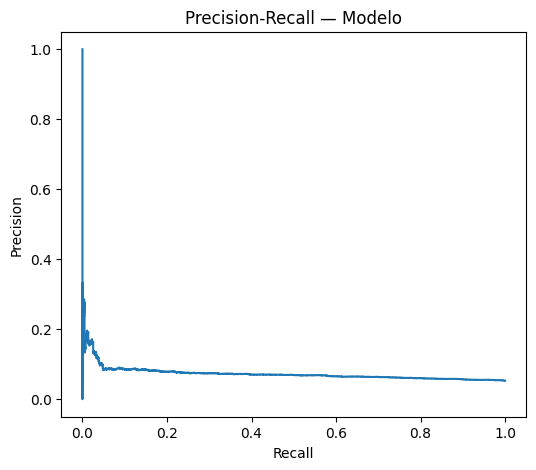

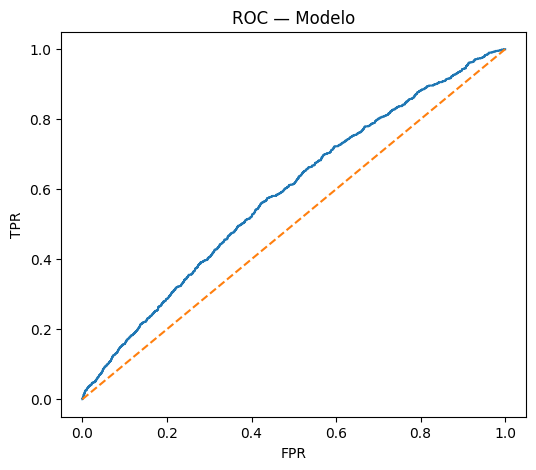

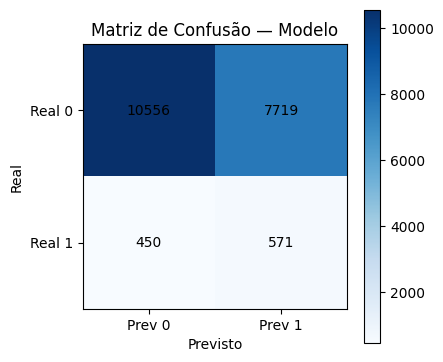

In [44]:

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import average_precision_score, roc_auc_score

# 1) Garante um pre-processamento SEM nome de colunas fixo (usa selectors)
def _ensure_pre():
    pre_existing = (globals().get('PRE') or globals().get('pre2') or globals().get('pre'))
    if pre_existing is not None:
        return pre_existing
    # fallback robusto: num -> median+scale, cat (não-numérico) -> most_frequent+OHE
    return ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imp', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler(with_mean=False)),
            ]), selector(dtype_include=np.number)),
            ('cat', Pipeline([
                ('imp', SimpleImputer(strategy='most_frequent')),
                ('ohe', OneHotEncoder(handle_unknown='ignore')),
            ]), selector(dtype_exclude=np.number)),
        ],
        remainder='drop',
        verbose_feature_names_out=False,
    )

def _build_lgbm(spw):
    return lgb.LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        # device='cuda',            # habilite se a sua build GPU estiver estável
        # gpu_use_dp=False,
        n_estimators=1200,
        learning_rate=0.05,
        num_leaves=128,
        max_depth=8,
        min_child_samples=30,
        subsample=0.85,
        colsample_bytree=0.9,
        reg_lambda=0.1,
        reg_alpha=0.01,
        min_split_gain=0.0,
        subsample_freq=1,
        max_bin=510,
        deterministic=True,
        n_jobs=1,                 # evita travar o Jupyter
        random_state=42,
        scale_pos_weight=spw,
        verbose=-1,
        metric='aucpr',
        force_row_wise=True       # bom com matriz esparsa do OHE
    )

def _as_pipeline(model, spw=None):
    """Se o 'model' já for Pipeline, retorna como está.
       Se for LGBMClassifier 'solto', embrulha com PRE."""
    if isinstance(model, Pipeline):
        return model
    pre = _ensure_pre()
    if isinstance(model, lgb.LGBMClassifier):
        return Pipeline([('pre', pre), ('model', model)])
    # nenhum modelo anterior: constrói um baseline
    spw = 1.0 if spw is None else spw
    return Pipeline([('pre', pre), ('model', _build_lgbm(spw))])

def temporal_split(df, timestamp_col='order_purchase_timestamp', test_size=0.2):
    if timestamp_col not in df.columns:
        raise KeyError(f"Coluna {timestamp_col} não encontrada no DataFrame.")
    dft = df[[timestamp_col]].copy()
    dft['_idx'] = np.arange(len(dft))
    dft = dft.sort_values(timestamp_col)
    cutoff = int(len(dft) * (1 - test_size))
    return dft.iloc[:cutoff]['_idx'].values, dft.iloc[cutoff:]['_idx'].values

# ================== MAIN ==================
try:
    df_for_temporal = df_model.copy()

    # monta X_full / y_full sincronizados ao df_model
    cols_drop = [
        'is_late','order_id','customer_id',
        'order_purchase_timestamp','order_delivered_customer_date',
        'order_estimated_delivery_date','order_approved_at',
        'ship_deadline_max','shipping_limit_date','order_status'
    ]
    cols_drop = [c for c in cols_drop if c in df_for_temporal.columns]
    X_full = df_for_temporal.drop(columns=cols_drop).copy()
    y_full = df_for_temporal['is_late'].astype(int).copy()

    # booleans -> int (ok; o resto fica como está para o OHE no pre)
    bool_cols = X_full.select_dtypes(include='boolean').columns
    if len(bool_cols) > 0:
        X_full[bool_cols] = X_full[bool_cols].astype('int8')

    if 'order_purchase_timestamp' in df_for_temporal.columns:
        tr_idx, te_idx = temporal_split(df_for_temporal.reset_index(drop=True),
                                        timestamp_col='order_purchase_timestamp',
                                        test_size=0.2)
        X_tr_t, X_te_t = X_full.iloc[tr_idx], X_full.iloc[te_idx]
        y_tr_t, y_te_t = y_full.iloc[tr_idx], y_full.iloc[te_idx]

        spw_t = (y_tr_t.value_counts()[0] / y_tr_t.value_counts()[1])

        # usa best_lgbm2 se existir, mas embrulha se não for Pipeline
        pipe_t = _as_pipeline(globals().get('best_lgbm2'), spw=spw_t)
        # adiciona logs de treino por iteração
        pipe_t.set_params(
            model__eval_set=[(X_te_t, y_te_t)],
            model__eval_metric='aucpr',
            model__callbacks=[
                lgb.log_evaluation(period=10),
                lgb.early_stopping(100, verbose=True),
            ],
        )

        pipe_t.fit(X_tr_t, y_tr_t)
        y_prob_t = pipe_t.predict_proba(X_te_t)[:, 1]
        pr_auc_t = average_precision_score(y_te_t, y_prob_t)
        roc_auc_t = roc_auc_score(y_te_t, y_prob_t)
        print(f"[Temporal] PR-AUC={pr_auc_t:.3f} | ROC-AUC={roc_auc_t:.3f}")

        try:
            evaluate_model(y_te_t, y_prob_t)
        except Exception:
            pass

    else:
        print("[Temporal] order_purchase_timestamp ausente; usando TimeSeriesSplit com ordenação por tempo.")
        order = df_model['order_purchase_timestamp'].values.argsort()
        X_ord = X_full.iloc[order].reset_index(drop=True)
        y_ord = y_full.iloc[order].reset_index(drop=True)

        tss = TimeSeriesSplit(n_splits=3)
        pr_scores, roc_scores = [], []
        for fold, (tr_idx, te_idx) in enumerate(tss.split(X_ord), 1):
            X_tr_t, X_te_t = X_ord.iloc[tr_idx], X_ord.iloc[te_idx]
            y_tr_t, y_te_t = y_ord.iloc[tr_idx], y_ord.iloc[te_idx]
            spw_t = (y_tr_t.value_counts()[0] / y_tr_t.value_counts()[1])

            pipe_t = _as_pipeline(globals().get('best_lgbm2'), spw=spw_t)
            pipe_t.set_params(
                model__eval_set=[(X_te_t, y_te_t)],
                model__eval_metric='aucpr',
                model__callbacks=[
                    lgb.log_evaluation(period=10),
                    lgb.early_stopping(100, verbose=True),
                ],
            )

            pipe_t.fit(X_tr_t, y_tr_t)
            y_prob_t = pipe_t.predict_proba(X_te_t)[:, 1]
            pr_scores.append(average_precision_score(y_te_t, y_prob_t))
            roc_scores.append(roc_auc_score(y_te_t, y_prob_t))
            print(f"[TSS fold {fold}] PR-AUC={pr_scores[-1]:.3f} | ROC-AUC={roc_scores[-1]:.3f}")

        print(f"[Temporal/TSS] PR-AUC={np.mean(pr_scores):.3f}±{np.std(pr_scores):.3f} | "
              f"ROC-AUC={np.mean(roc_scores):.3f}±{np.std(roc_scores):.3f}")

except Exception as e:
    print("[Temporal] Falha controlada:", e)


## 16. Artefatos de Produção (joblib + script de inferência)

Abaixo salvamos o **pipeline vencedor** em disco e geramos um **script de inferência** (`predict.py`) para uso externo, além de um `requirements.txt` mínimo para reprodutibilidade.
